# Подготовка данных

Авторы в статье использавали весь датасет https://ai.google.com/research/ConceptualCaptions/   Conceptual Captions (CC3M) для обучения модели, который включает в себя 3,3 млн пар текст-изображение. Так как изображение представлено в виде url и нужно время, чтобы его скачать, то для воспроизведения эксперимента авторов я воспользуюсь только небольшим семплингом из 500 пар. В этом ноутбуке я использую данные с hugging face, делаю небольшую предобработку и сохраняю изображения для работы модели.

In [1]:
from concurrent.futures import ThreadPoolExecutor
from functools import partial
import io
import urllib

import PIL.Image

from datasets import load_dataset
from datasets.utils.file_utils import get_datasets_user_agent


USER_AGENT = get_datasets_user_agent()


def fetch_single_image(image_url, timeout=None, retries=0):
    for _ in range(retries + 1):
        try:
            request = urllib.request.Request(
                image_url,
                data=None,
                headers={"user-agent": USER_AGENT},
            )
            with urllib.request.urlopen(request, timeout=timeout) as req:
                image = PIL.Image.open(io.BytesIO(req.read()))
            break
        except Exception:
            image = None
    return image


def fetch_images(batch, num_threads, timeout=None, retries=0):
    fetch_single_image_with_args = partial(fetch_single_image, timeout=timeout, retries=retries)
    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        batch["image"] = list(executor.map(fetch_single_image_with_args, batch["image_url"]))
    return batch


num_threads = 20
dset = load_dataset("conceptual_captions", 'unlabeled', split = 'validation')
#dset = dset.map(fetch_images, batched=True, batch_size=100, fn_kwargs={"num_threads": num_threads})

Found cached dataset conceptual_captions (C:/Users/Kate/.cache/huggingface/datasets/conceptual_captions/unlabeled/1.0.0/05266784888422e36944016874c44639bccb39069c2227435168ad8b02d600d8)


In [2]:
dset = dset.shuffle(seed=3).select(range(500)).map(fetch_images, batched=True, batch_size=15, fn_kwargs={"num_threads": num_threads})

Loading cached shuffled indices for dataset at C:\Users\Kate\.cache\huggingface\datasets\conceptual_captions\unlabeled\1.0.0\05266784888422e36944016874c44639bccb39069c2227435168ad8b02d600d8\cache-ccf370958cbb5619.arrow


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [8]:
dset

Dataset({
    features: ['image_url', 'caption', 'image'],
    num_rows: 500
})

In [9]:
dset_filtered = dset.filter(lambda example: example["image"] != None)
dset_filtered

Loading cached processed dataset at C:\Users\Kate\.cache\huggingface\datasets\conceptual_captions\unlabeled\1.0.0\05266784888422e36944016874c44639bccb39069c2227435168ad8b02d600d8\cache-108ade90d4f89fc9.arrow


Dataset({
    features: ['image_url', 'caption', 'image'],
    num_rows: 371
})

C:\Users\Kate\AppData\Local\Temp\ipykernel_26840\4209736898.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


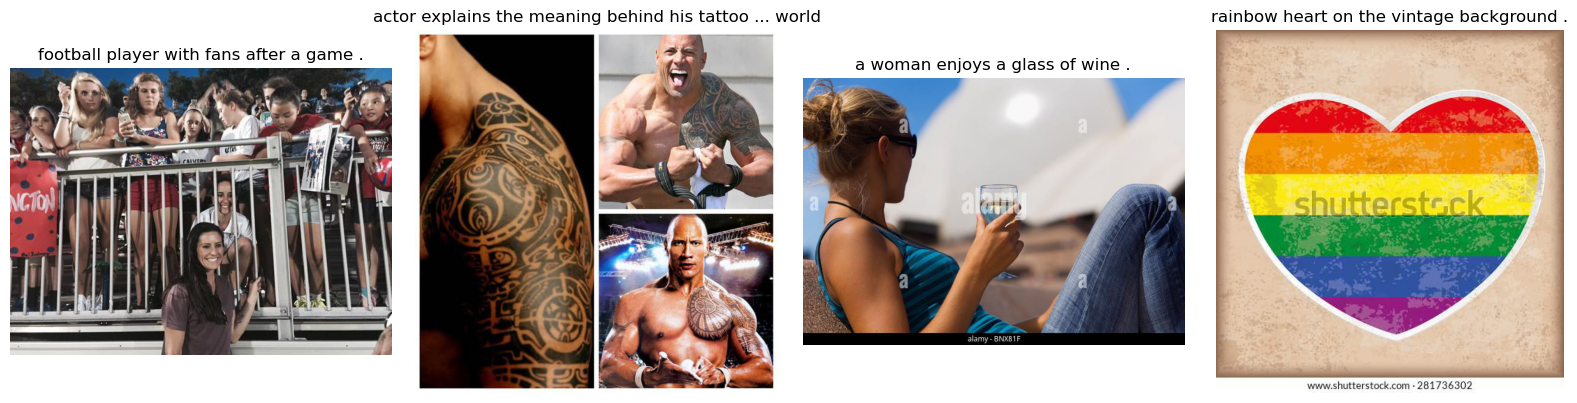

In [10]:
import matplotlib.pyplot as plt
import random

num_samples = 4
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i in range(num_samples):
    random_item = random.choice(dset_filtered)
    axs[i].imshow(random_item["image"])
    title = random_item["caption"]
    title = title.strip()
    axs[i].set_title(title)
    axs[i].set_axis_off()
fig.tight_layout()
fig.show()

In [6]:
dset_filtered.save_to_disk("filtered.hf")

Saving the dataset (0/1 shards):   0%|          | 0/371 [00:00<?, ? examples/s]

In [7]:
from datasets import load_from_disk

reloaded_encoded_dataset = load_from_disk("filtered.hf")
reloaded_encoded_dataset

Dataset({
    features: ['image_url', 'caption', 'image'],
    num_rows: 371
})